In [8]:
import torch
import json
import h5py
import random
import numpy as np
from matplotlib.pyplot import imshow
from PIL import Image, ImageDraw

In [9]:
# load the following to files from DETECTED_SGG_DIR
custom_prediction = json.load(open('/home/maelic/Documents/Scene-Graph-Benchmark-Cuda11.7/demo/final_comparison/baseline/custom_prediction.json'))
custom_data_info = json.load(open('/home/maelic/Documents/Scene-Graph-Benchmark-Cuda11.7/demo/final_comparison/baseline/custom_data_info.json'))

In [10]:
def draw_single_box(pic, box, color='red', draw_info=None):
    draw = ImageDraw.Draw(pic)
    x1,y1,x2,y2 = int(box[0]), int(box[1]), int(box[2]), int(box[3])
    draw.rectangle(((x1, y1), (x2, y2)), outline=color)
    if draw_info:
        draw.rectangle(((x1, y1), (x1+50, y1+10)), fill=color)
        info = draw_info
        draw.text((x1, y1), info)
        
def print_list(name, input_list, scores=None):
    for i, item in enumerate(input_list):
        if scores == None:
            print(name + ' ' + str(i) + ': ' + str(item))
        else:
            print(name + ' ' + str(i) + ': ' + str(item) + '; score: ' + str(scores[i]))
    
def draw_image(img_path, boxes, box_labels, rel_labels, box_scores=None, rel_scores=None):
    size = get_size(Image.open(img_path).size)
    pic = Image.open(img_path).resize(size)
    num_obj = len(boxes)
    for i in range(num_obj):
        info = str(i) + '_' + box_labels[i]
        draw_single_box(pic, boxes[i], draw_info=info)
    display(pic)
    # print('*' * 50)
    # print_list('box_labels', box_labels, box_scores)
    print('*' * 50)
    print_list('rel_labels', rel_labels, rel_scores)
    
    return None

def get_size(image_size):
    min_size = 600
    max_size = 1000
    w, h = image_size
    size = min_size
    if max_size is not None:
        min_original_size = float(min((w, h)))
        max_original_size = float(max((w, h)))
        if max_original_size / min_original_size * size > max_size:
            size = int(round(max_size * min_original_size / max_original_size))
    if (w <= h and w == size) or (h <= w and h == size):
        return (w, h)
    if w < h:
        ow = size
        oh = int(size * h / w)
    else:
        oh = size
        ow = int(size * w / h)
    return (ow, oh)

def draw_single_label(pic, box, label, color=(255,0,255,128)):
    draw = ImageDraw.Draw(pic)
    x1,y1,x2,y2 = int(box[0]), int(box[1]), int(box[2]), int(box[3])
    p1 = (x1, y1)
    p2 = (x2, y2)
    bb_center = (int(p1[0] + p2[0])/2, int(p1[1] + p2[1])/2)

    bbox = draw.textbbox(bb_center, label)
    draw.rectangle(bbox, fill=color)
    draw.text(bb_center, label, fill="white")
    return bb_center

def draw_rel(pic, c1,c2, label, color=(0,255,255,128)):
    draw = ImageDraw.Draw(pic)
    draw.line((c1, c2), fill=color)
    bb_center = (c1[0] + c2[0]) / 2, (c1[1] + c2[1]) / 2
    bbox = draw.textbbox(bb_center, label)
    draw.rectangle(bbox, fill=color)
    draw.text(bb_center, label, fill="white")

    return bb_center

def show_all_rel_on_image(img_path, boxes, box_labels, all_rel_pairs, all_rel_labels, ind_to_predicates, all_rel_scores, box_scores, box_topk=20, rel_thres=0.5):
    rel_scores = []
    size = get_size(Image.open(img_path).size)
    pic = Image.open(img_path).resize(size)
    global_score = {}
    for i in range(len(all_rel_pairs)):
        # get corresponding boxes score:
        subj_score = box_scores[all_rel_pairs[i][0]]
        obj_score = box_scores[all_rel_pairs[i][1]]
        # if both boxes have high scores, draw the relationship:
        global_score[i] = (subj_score + obj_score + float(all_rel_scores[i]))/3
    # sort the relationship by global score:
    sorted_rel = sorted(global_score.items(), key=lambda x: x[1], reverse=True)
    # slice the topk relationship:
    sorted_rel = dict(sorted_rel[:box_topk])

    for i in list(sorted_rel.keys()):
        # get corresponding boxes score:
        subj_score = box_scores[all_rel_pairs[i][0]]
        obj_score = box_scores[all_rel_pairs[i][1]]
        # if both boxes have high scores, draw the relationship:

        rel_scores.append(all_rel_scores[i])
        subj_label = str(all_rel_pairs[i][0]) + '_' + box_labels[all_rel_pairs[i][0]]
        obj_label =  str(all_rel_pairs[i][1]) + '_' + box_labels[all_rel_pairs[i][1]]
        pred_label = ind_to_predicates[all_rel_labels[i]]
        # get corresponding bounding boxes:
        subj_box = boxes[all_rel_pairs[i][0]]
        obj_box = boxes[all_rel_pairs[i][1]]
        # draw the relationship:
        c1 = draw_single_label(pic, subj_box, subj_label)
        c2 = draw_single_label(pic, obj_box, obj_label)
        draw_rel(pic, c1, c2, pred_label)

    return display(pic)

In [11]:
# parameters
image_idx = 11
box_topk = 20 # select top k bounding boxes
rel_topk = 20 # select top k relationships
ind_to_classes = custom_data_info['ind_to_classes']
ind_to_predicates = custom_data_info['ind_to_predicates']

[49, 53, 5, 33, 65]


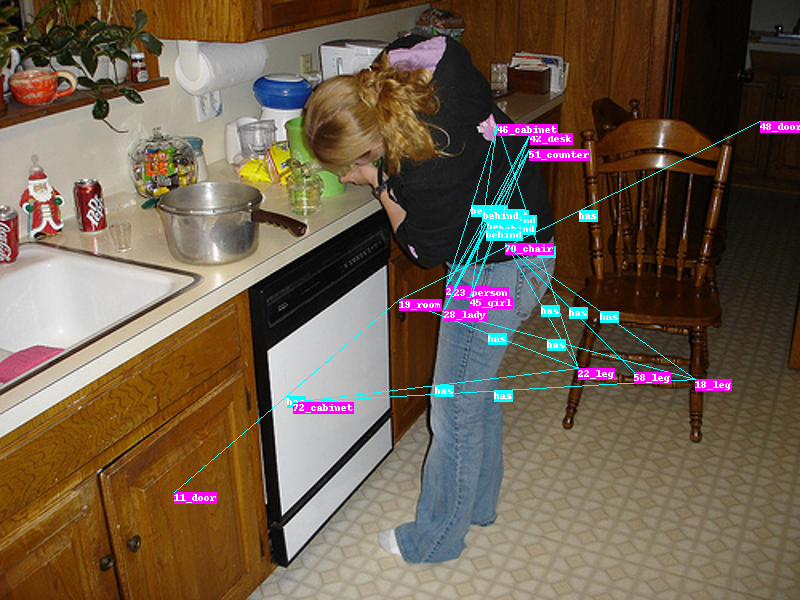

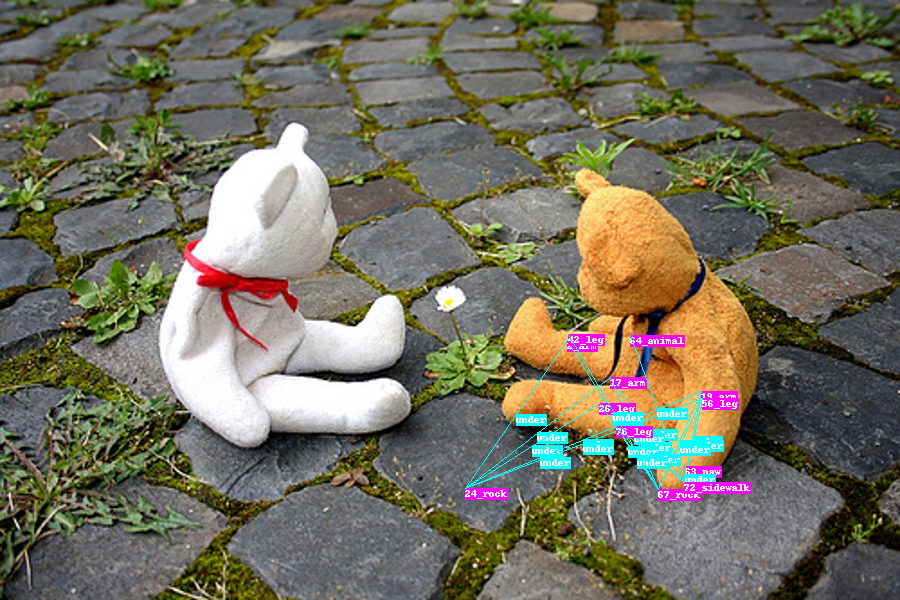

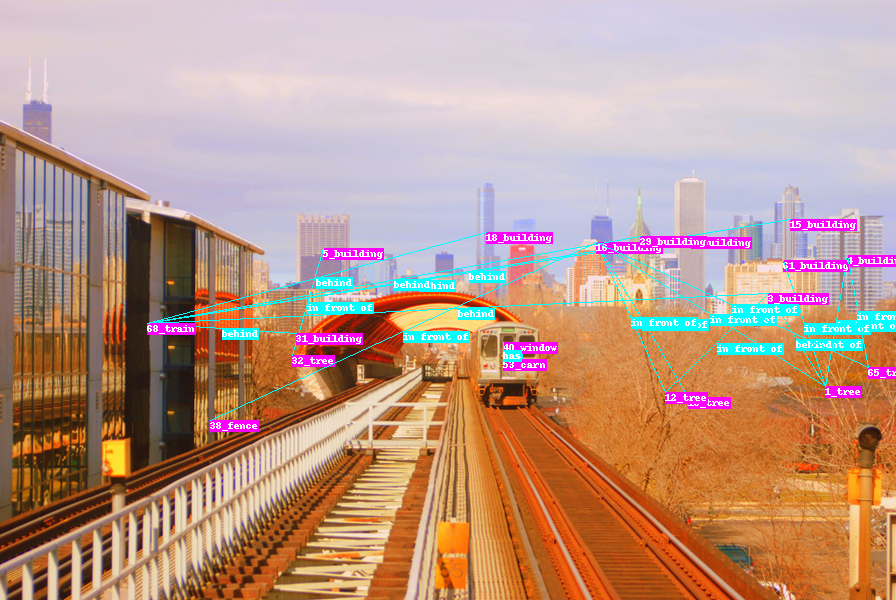

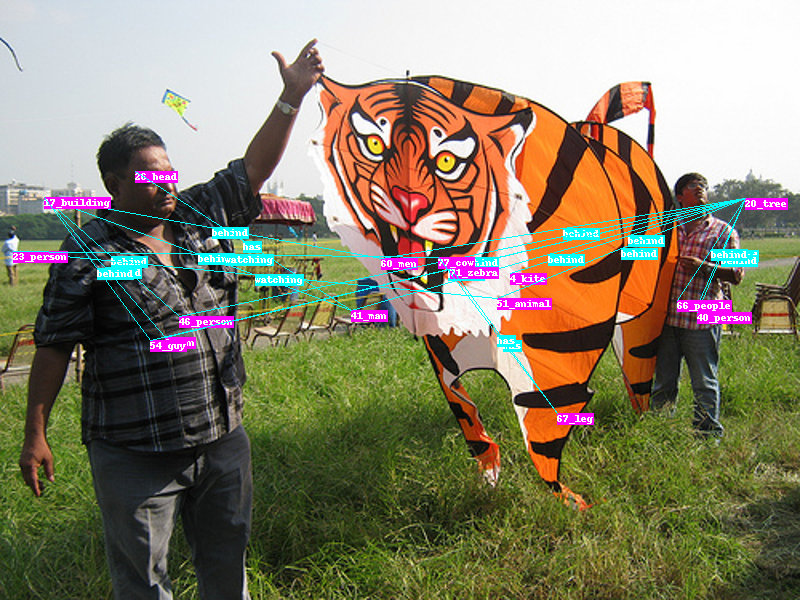

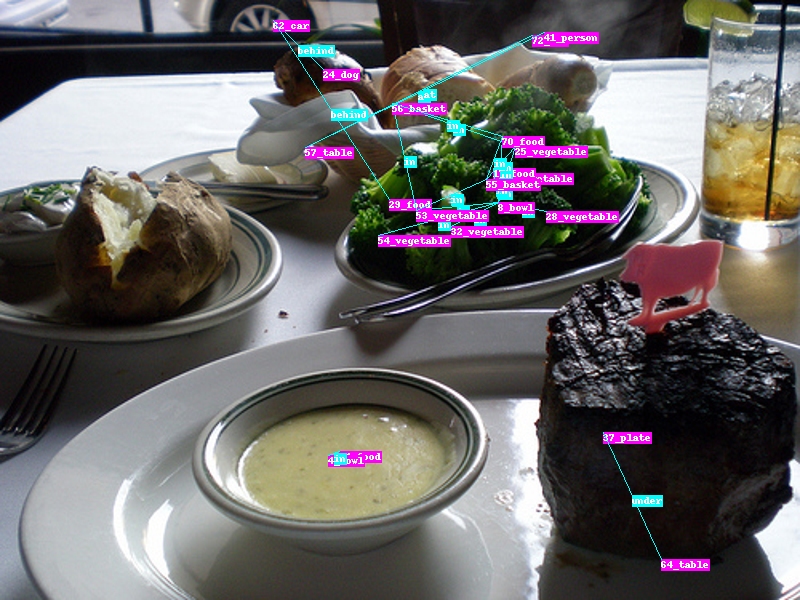

NameError: name 'ind_to_classes' is not defined

In [13]:
# get 5 random numbers between 0 and 100:
random.seed(0)
random_list = random.sample(range(0, 96), 5)
print(random_list)
for image_idx in random_list:
    image_path = custom_data_info['idx_to_files'][image_idx]
    boxes = custom_prediction[str(image_idx)]['bbox']
    box_labels = custom_prediction[str(image_idx)]['bbox_labels']
    box_scores = custom_prediction[str(image_idx)]['bbox_scores']
    all_rel_labels = custom_prediction[str(image_idx)]['rel_labels'][:box_topk]
    all_rel_scores = custom_prediction[str(image_idx)]['rel_scores'][:box_topk]
    all_rel_pairs = custom_prediction[str(image_idx)]['rel_pairs'][:box_topk]
    for i in range(len(box_labels)):
        try:
            box_labels[i] = ind_to_classes[box_labels[i]]
        except:
            pass

    # rel_labels = []
    # rel_scores = []
    # for i in range(len(all_rel_pairs)):
    #     if all_rel_pairs[i][0] < box_topk and all_rel_pairs[i][1] < box_topk:
    #         rel_scores.append(all_rel_scores[i])
    #         label = str(all_rel_pairs[i][0]) + '_' + box_labels[all_rel_pairs[i][0]] + ' => ' + ind_to_predicates[all_rel_labels[i]] + ' => ' + str(all_rel_pairs[i][1]) + '_' + box_labels[all_rel_pairs[i][1]]
    #         rel_labels.append(label)

    # rel_labels = rel_labels[:rel_topk]
    # rel_scores = rel_scores[:rel_topk]

    show_all_rel_on_image(image_path, boxes, box_labels, all_rel_pairs, all_rel_labels, ind_to_predicates, all_rel_scores, box_scores, box_topk=20, rel_thres=0.9)

del ind_to_classes
del box_labels
